In [157]:
# tensorflow
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import datetime

# fix the seed for consistent interpretation of the results
import random as python_random
python_random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

Using TensorFlow v2.4.1


In [158]:
from tqdm.notebook import tqdm

In [159]:
from scrinet.interfaces import lalutils

import lal
import lalsimulation as lalsim

import utils

In [160]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS 

In [161]:
import phenom

In [162]:
# https://stackoverflow.com/questions/59563085/how-to-stop-training-when-it-hits-a-specific-validation-accuracy
class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, val):
        super(ThresholdCallback, self).__init__()
        self.val = val
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') <= self.val:
            self.model.stop_training = True

In [163]:
def gen_model_waveforms(approx, qlist, npts, t_min, t_max, nrfiles=None):
    if approx == "NR":
        return [utils.WaveformGeneration(nrfile=nrfiles[key], npts=npts, t_min=t_min, t_max=t_max) for key in nrfiles]
    else:
        lal_approx = lalsim.GetApproximantFromString(approx)
        return [utils.WaveformGeneration(approximant=lal_approx, q=q, npts=npts, t_min=t_min, t_max=t_max) for q in qlist]

In [164]:
def make_training_set(wfs, attr, scale_by_eta=False):
    """
    make a numpy array of training data
    """
    x = np.array([wf.__getattribute__('q') for wf in wfs])
    y = np.array([wf.__getattribute__(attr) for wf in wfs])
    
    if scale_by_eta:
        eta = phenom.eta_from_q(x)[:, np.newaxis]
        return {'x':x, 'y':y/eta}
    else:
        return {'x':x, 'y':y}

In [165]:
def generate_case(q, approx="SEOBNRv4_opt", npts=1000, t_min=-2000, t_max=75, data_to_model='phase', scale_by_eta=False):
    model_wf = gen_model_waveforms(approx, np.atleast_1d(q), npts, t_min=t_min, t_max=t_max)
    return make_training_set(model_wf, data_to_model, scale_by_eta=scale_by_eta)

In [166]:
def build_encoder(input_shape, latent_dim, act="relu"):
    # build the encoder
    timeseries_input = keras.Input(shape=(input_shape, ))
    x = layers.Dense(128, activation=act)(timeseries_input)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(64, activation=act)(x)
    x = layers.Dense(16, activation=act)(x)
#     x = layers.Dense(16, activation="tanh")(x)
    latent_output = layers.Dense(latent_dim)(x)
    encoder_AE = keras.Model(timeseries_input, latent_output)
#     encoder_AE.summary()
    
    return encoder_AE

In [167]:
def build_decoder(input_shape, latent_dim, act="relu"):
    # build the decoder
    latent_input = keras.Input(shape=(latent_dim,))
    x = layers.Dense(16, activation=act)(latent_input)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(64, activation=act)(x)
    x = layers.Dense(128, activation=act)(x)
#     x = layers.Dense(128, activation="tanh")(x)
    timeseries_output = layers.Dense(input_shape, activation="linear")(x)
    decoder_AE = keras.Model(latent_input, timeseries_output)
#     decoder_AE.summary()
    
    return decoder_AE

In [168]:
def build_and_compile_autoencoder(input_shape, encoder_AE, decoder_AE, opt):
    # build the AE
    timeseries_input = keras.Input(shape=(input_shape, ))
    latent = encoder_AE(timeseries_input)
    timeseries_output = decoder_AE(latent)
    ae_model = keras.Model(timeseries_input, timeseries_output)
#     ae_model.summary()

    ae_model.compile(optimizer=opt, loss='mse')
    
    return ae_model

In [169]:
def plot_latent_space_1d_for_each_model(model_ts, encoder_AE, figsize=None):
    xs = np.asarray([model_ts[k]['x'] for k in model_ts.keys()])
    ys = np.asarray([model_ts[k]['y'] for k in model_ts.keys()])
    
    latent_space = np.asarray([encoder_AE.predict(y) for y in ys])
    
    print(xs.shape)
    print(ys.shape)
    print(latent_space.shape)
    
    for i in range(latent_space.shape[2]):
        plt.figure(figsize=figsize)
        for n,k in enumerate(model_ts.keys()):
            plt.plot(xs[n], latent_space[n,:,i], '-', label=f'{k}')
        plt.legend()
        plt.title(f'latent space: {i}')
        plt.show()
        plt.close()

In [170]:
def interpolate_latent_space_min_max(model_ts, encoder_AE):
    """
    assumes that xs array are the same. would have to resample all to same grid in the future
    """
    xs = np.asarray([model_ts[k]['x'] for k in model_ts.keys()])
    ys = np.asarray([model_ts[k]['y'] for k in model_ts.keys()])
    
    latent_space = np.asarray([encoder_AE.predict(y) for y in ys])
    
    y_mins = np.min(latent_space, axis=0)
    y_maxs = np.max(latent_space, axis=0)
    
    results = {}
    labels = ['min', 'max']
    for k in labels:
        interpolations = []
        if k == 'min':
            y = y_mins
        elif k == 'max':
            y = y_maxs
        for i in range(latent_space.shape[2]):
            interpolations.append(IUS(xs[0], y[:,i]))
        results.update({k:interpolations})
    
    return results

In [171]:
def interpolate_latent_space(model_ts, encoder_AE):
    xs = np.asarray([model_ts[k]['x'] for k in model_ts.keys()])
    ys = np.asarray([model_ts[k]['y'] for k in model_ts.keys()])
    
    latent_space = np.asarray([encoder_AE.predict(y) for y in ys])

    results = {}
    
    for n, k in enumerate(model_ts.keys()):
        interpolations = []
        for i in range(latent_space.shape[2]):
            interpolations.append(IUS(xs[n], latent_space[n,:,i]))
        results.update({k:interpolations})
    
    return results

In [172]:
def plot_prediction(index, n_samples=0):
    
    latent_true = train_encodings_AE[index][np.newaxis,:]
    
    if n_samples:
        rvs = np.random.uniform(latent_true-0.1, latent_true+0.1, size=(n_samples, latent_dim))
        yhats = decoder_AE.predict(rvs)
        yhats_min = np.min(yhats, axis=0)
        yhats_max = np.max(yhats, axis=0)
    
    plt.figure(figsize=(18, 10))
    
    if n_samples:
        plt.fill_between(common_times, y1=yhats_min, y2=yhats_max, color='g', alpha=0.2)
        
        for yh in yhats:
            plt.plot(common_times, yh, lw=1, color='k', alpha=0.2)
    
    plt.plot(common_times, train_y[index], lw=2)
    plt.plot(common_times, decoder_AE.predict(latent_true)[0], ls='--', lw=2)
    
    plt.title(f'mass-ratio: {train_x[index]}')
    
#     plt.xlim(-100, 100)
#     plt.yscale('log')
    plt.show()
    plt.close()

In [173]:
def predict(q, decoder_AE, latent_space_interpolations):
    latent_space = np.asarray([f(q) for f in latent_space_interpolations])
    latent_space = latent_space[np.newaxis, :]

    return decoder_AE.predict(latent_space)

In [174]:
def match(h1, h2, times):

    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df

    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)

    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm

    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)


    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    res = ifft / h1h1 / h2h2 * 4 * dt

    return np.max(np.abs(res))


# main

In [175]:
def run_ae_fit(train_y, epochs, batch_size, stop_threshold, latent_dim=2):
    act = "relu"
    # act = "tanh"
    input_shape = train_y.shape[1] # number of time points
    learning_rate=0.001
    amsgrad=True
    # opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=amsgrad)
    # opt = tfa.optimizers.NovoGrad(learning_rate=learning_rate, amsgrad=amsgrad)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate)
    # opt = tfa.optimizers.LAMB(learning_rate=learning_rate)
    # opt = tfa.optimizers.Yogi(learning_rate=learning_rate)
    # opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
    # opt = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    # opt = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
    # opt = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    # opt = tfa.optimizers.Lookahead(opt)

    encoder_AE = build_encoder(input_shape, latent_dim, act)
    decoder_AE = build_decoder(input_shape, latent_dim, act)
    ae_model = build_and_compile_autoencoder(input_shape, encoder_AE, decoder_AE, opt)
    # encoder_AE.summary()
    # decoder_AE.summary()
    # ae_model.summary()


    callbacks = []

    # first_decay_steps = 20
    # first_decay_steps = 400
    # first_decay_steps = 1200*4
    # learning_rate_fn = tf.keras.experimental.CosineDecayRestarts(learning_rate, first_decay_steps)

    # learning_rate_fn = tfa.optimizers.ExponentialCyclicalLearningRate(learning_rate, 1e-8, first_decay_steps)
    # learning_rate_fn = tfa.optimizers.ExponentialCyclicalLearningRate(1e-8, learning_rate, first_decay_steps, gamma=0.999)

    initial_learning_rate=1e-6
    maximal_learning_rate=1e-2
    step_size=200
    gamma=0.7
    # initial_learning_rate=1e-3
    # maximal_learning_rate=1e-2
    # step_size=1000
    # gamma=1

    learning_rate_fn = tfa.optimizers.ExponentialCyclicalLearningRate(
                initial_learning_rate=initial_learning_rate,
                maximal_learning_rate=maximal_learning_rate,
                step_size=step_size,
                scale_mode="cycle",
                gamma=gamma)


    callbacks.append(tf.keras.callbacks.LearningRateScheduler(learning_rate_fn))

    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)

    callbacks.append(ThresholdCallback(stop_threshold))
    
#     callbacks.append(ThresholdCallback(1e-4)) # for the phase if it hasn't been normalised
    # callbacks.append(ThresholdCallback(1e-7))
    
    start_time = datetime.datetime.now()
    ae_history = ae_model.fit(train_y, train_y, epochs=epochs, callbacks=callbacks, batch_size=batch_size, verbose=0)
    end_time = datetime.datetime.now()
    
    duration = end_time - start_time
    print("fit complete")
    print(f"duration: {duration}")
    
    plt.figure()
    plt.plot(ae_history.history['loss'])
    # plt.plot(ae_history.history['val_loss'])
    plt.yscale('log')
    plt.xscale('log')
    
    return ae_model, ae_history, encoder_AE, decoder_AE

# common hyper parameters

In [176]:
# define hyper-parameters

# approxs = ["SEOBNRv4_opt", "IMRPhenomB", "IMRPhenomC", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", 'IMRPhenomT', 'IMRPhenomXAS', "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "NR"]
# approxs = ["SEOBNRv4_opt", "SEOBNRv4"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "IMRPhenomC"]
# approxs = ["SEOBNRv4_opt"]
# approxs = ["IMRPhenomD"]
approxs = ["IMRPhenomC"]


start_approx = approxs[0]
q_min = 1
# q_max = 2
q_max = 19
# q_min = 19
# q_max = 30
dq = 0.1

q_arr = np.arange(q_min, q_max, dq)

# time points
# npts=1000
npts=5000
# t_min=-500
t_min=-2000
t_max=75

In [177]:
model_wfs = {}
for approx in approxs:
    model_wfs.update({approx:gen_model_waveforms(approx, q_arr, npts, t_min=t_min, t_max=t_max)})

In [178]:
common_times = model_wfs[start_approx][0].times

In [179]:
model_ts = {}

In [180]:
train_x = {}
train_y = {}

In [181]:
scale_param = {}

In [182]:
ae_model = {}
ae_history = {}
encoder = {}
decoder = {}

In [183]:
train_encodings_AE = {}

In [184]:
interpolations = {}

In [185]:
interpolations_min_max = {}

# amp data

In [186]:
# data_to_model = 'Reh22'
data_to_model = 'amp'
# data_to_model = 'phase'
# data_to_model = 'freq'

scale_by_eta=True
# scale_by_eta=False

In [187]:
# model_grb_ts: the greedy reduced basis training set for each model
model_ts[data_to_model] = {}
for approx in approxs:
    model_ts[data_to_model].update({approx:make_training_set(model_wfs[approx], data_to_model, scale_by_eta=scale_by_eta)})

In [188]:
# the training set will just be the concatonated list of all waveforms
# from each model
train_x[data_to_model] = np.concatenate([model_ts[data_to_model][k]['x'] for k in model_ts[data_to_model].keys()])
train_y[data_to_model] = np.concatenate([model_ts[data_to_model][k]['y'] for k in model_ts[data_to_model].keys()])

In [189]:
train_y[data_to_model].shape

(180, 5000)

In [190]:
train_x[data_to_model].shape

(180,)

In [191]:
scale_param[data_to_model] = np.max(train_y[data_to_model])
train_y[data_to_model] = train_y[data_to_model]/scale_param[data_to_model]
for approx in approxs:
    model_ts[data_to_model][approx]['y'] = model_ts[data_to_model][approx]['y']/scale_param[data_to_model]

## fits


fit complete
duration: 0:10:34.888379


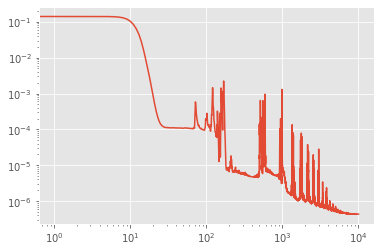

In [192]:
data_to_model = 'amp'
# stop_threshold=5e-5
top_threshold=1e-7
# stop_threshold=5e-8
epochs=10000
# epochs=500
ae_model[data_to_model], ae_history[data_to_model], encoder[data_to_model], decoder[data_to_model] = run_ae_fit(train_y=train_y[data_to_model], epochs=epochs, batch_size=32, stop_threshold=stop_threshold, latent_dim=2)

In [193]:
train_encodings_AE[data_to_model] = encoder[data_to_model].predict(train_y[data_to_model])

In [194]:
train_encodings_AE[data_to_model].shape

(180, 2)

(1, 180)
(1, 180, 5000)
(1, 180, 2)


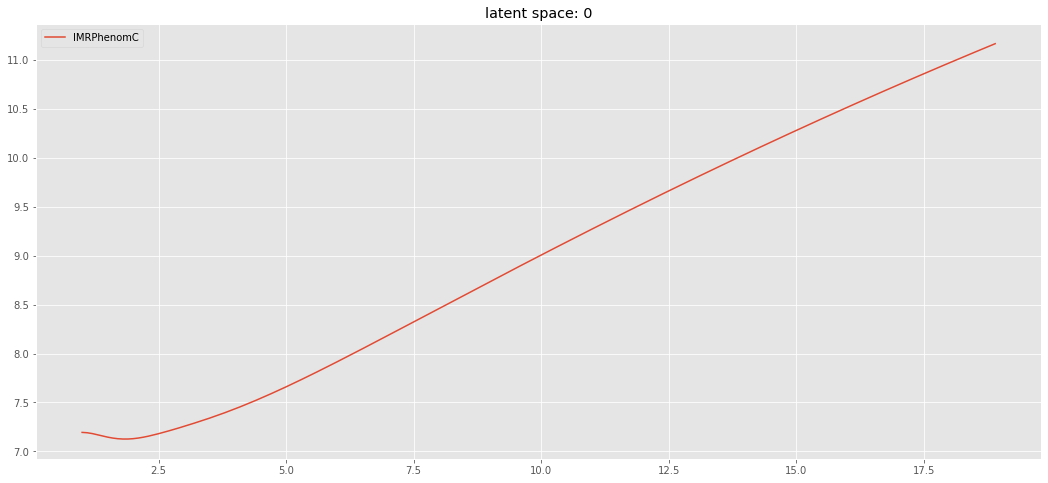

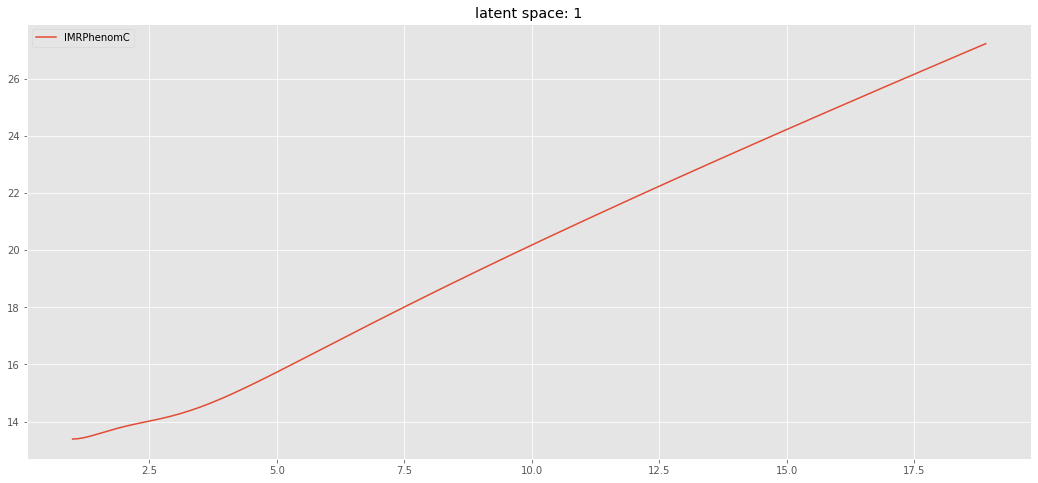

In [195]:
plot_latent_space_1d_for_each_model(model_ts[data_to_model], encoder[data_to_model], figsize=(18, 8))

In [196]:
interpolations_min_max[data_to_model] = interpolate_latent_space_min_max(model_ts[data_to_model], encoder[data_to_model])

In [197]:
interpolations[data_to_model] = interpolate_latent_space(model_ts[data_to_model], encoder[data_to_model])

In [198]:
# plt.figure()
# plt.plot(model_ts[data_to_model]['IMRPhenomD']['x'], interpolations[data_to_model]['IMRPhenomD'][0](model_ts[data_to_model]['IMRPhenomD']['x']))

In [199]:
# predict(1, decoder[data_to_model], interpolations[data_to_model]['IMRPhenomD'])

# phase data

In [200]:
# data_to_model = 'Reh22'
# data_to_model = 'amp'
data_to_model = 'phase'
# data_to_model = 'freq'

# scale_by_eta=True
scale_by_eta=False

In [201]:
# model_grb_ts: the greedy reduced basis training set for each model
model_ts[data_to_model] = {}
for approx in approxs:
    model_ts[data_to_model].update({approx:make_training_set(model_wfs[approx], data_to_model, scale_by_eta=scale_by_eta)})

In [202]:
# the training set will just be the concatonated list of all waveforms
# from each model
train_x[data_to_model] = np.concatenate([model_ts[data_to_model][k]['x'] for k in model_ts[data_to_model].keys()])
train_y[data_to_model] = np.concatenate([model_ts[data_to_model][k]['y'] for k in model_ts[data_to_model].keys()])

In [203]:
train_y[data_to_model].shape

(180, 5000)

In [204]:
train_x[data_to_model].shape

(180,)

In [205]:
scale_param[data_to_model] = np.min(train_y[data_to_model])
train_y[data_to_model] = train_y[data_to_model]/scale_param[data_to_model]
for approx in approxs:
    model_ts[data_to_model][approx]['y'] = model_ts[data_to_model][approx]['y']/scale_param[data_to_model]

## fits


fit complete
duration: 0:02:49.018269


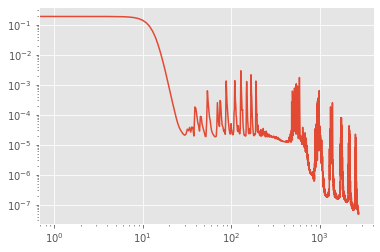

In [206]:
data_to_model = 'phase'
stop_threshold=5e-8
ae_model[data_to_model], ae_history[data_to_model], encoder[data_to_model], decoder[data_to_model] = run_ae_fit(train_y=train_y[data_to_model], epochs=10000, batch_size=32, stop_threshold=stop_threshold, latent_dim=2)

In [207]:
train_encodings_AE[data_to_model] = encoder[data_to_model].predict(train_y[data_to_model])

In [208]:
train_encodings_AE[data_to_model].shape

(180, 2)

(1, 180)
(1, 180, 5000)
(1, 180, 2)


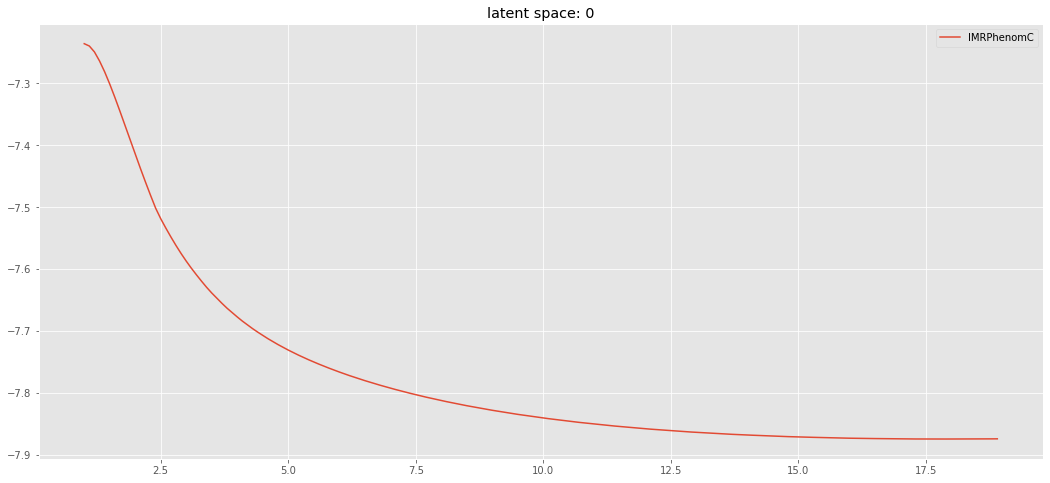

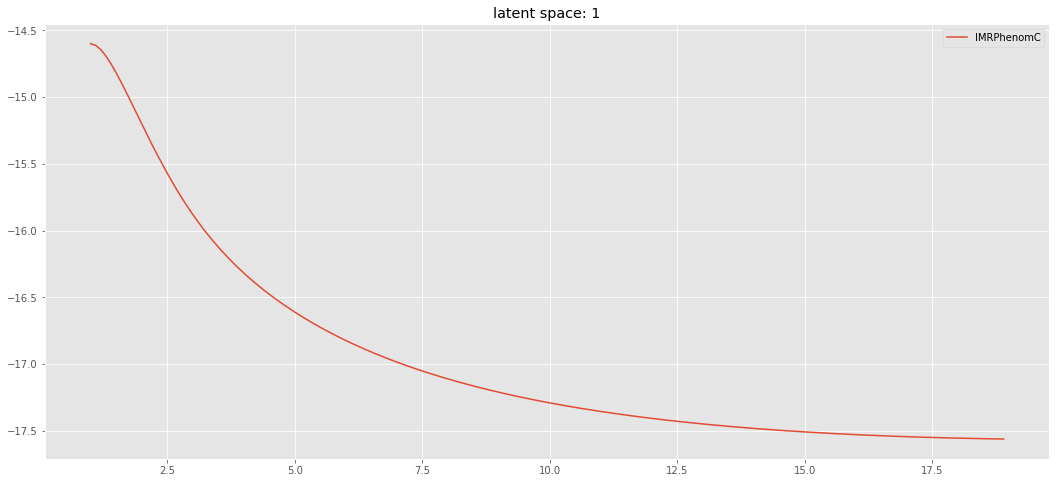

In [209]:
plot_latent_space_1d_for_each_model(model_ts[data_to_model], encoder[data_to_model], figsize=(18, 8))

In [210]:
interpolations_min_max[data_to_model] = interpolate_latent_space_min_max(model_ts[data_to_model], encoder[data_to_model])

In [211]:
interpolations[data_to_model] = interpolate_latent_space(model_ts[data_to_model], encoder[data_to_model])

In [212]:
# plt.figure()
# plt.plot(model_ts[data_to_model]['IMRPhenomD']['x'], interpolations[data_to_model]['IMRPhenomD'][0](model_ts[data_to_model]['IMRPhenomD']['x']))

In [343]:
def compare_with_models(q, decoder_amp, decoder_phase, amp_interpolations, phase_interpolations, base_model):
    
    other_model = generate_case(q, approx=base_model, data_to_model='Reh22', scale_by_eta=True, npts=5000)
    
    
    amphat = predict(q, decoder_amp, amp_interpolations[base_model]) * scale_param['amp']
    phasehat = predict(q, decoder_phase, phase_interpolations[base_model]) * scale_param['phase']
    
    hhat = amphat * np.exp(-1.j * phasehat)
    
    wave1 = other_model['y'][0]
    wave2 = np.real(hhat[0])
#     wave2_amp = np.abs(hhat[0])
    
    print(f"mass-ratio: {q}")
    print(f"match: {match(wave1, wave2, common_times)}")
    print(f"comparing with base_model: {base_model}")
    
    plt.figure(figsize=(22, 12))
    plt.subplot(2, 1, 1)
    plt.plot(common_times, wave1)
    plt.plot(common_times, wave2, ls='--')
#     plt.plot(common_times, wave2_amp, ls='--')
    
    plt.subplot(2, 1, 2)
    plt.plot(common_times, wave1)
    plt.plot(common_times, wave2, ls='--')
#     plt.plot(common_times, wave2_amp, ls='--')
    plt.xlim(-100, 100)

In [344]:
# compare_with_models(np.around(np.random.uniform(1, 18), 3), decoder['amp'], decoder['phase'], interpolations['amp'], interpolations['phase'], base_model='IMRPhenomD')

In [345]:
# compare_with_models(np.around(np.random.uniform(1, 18), 3), decoder['amp'], decoder['phase'], interpolations['amp'], interpolations['phase'], base_model='SEOBNRv4_opt')

mass-ratio: 16.241
match: 0.9997657250640106
comparing with base_model: IMRPhenomC


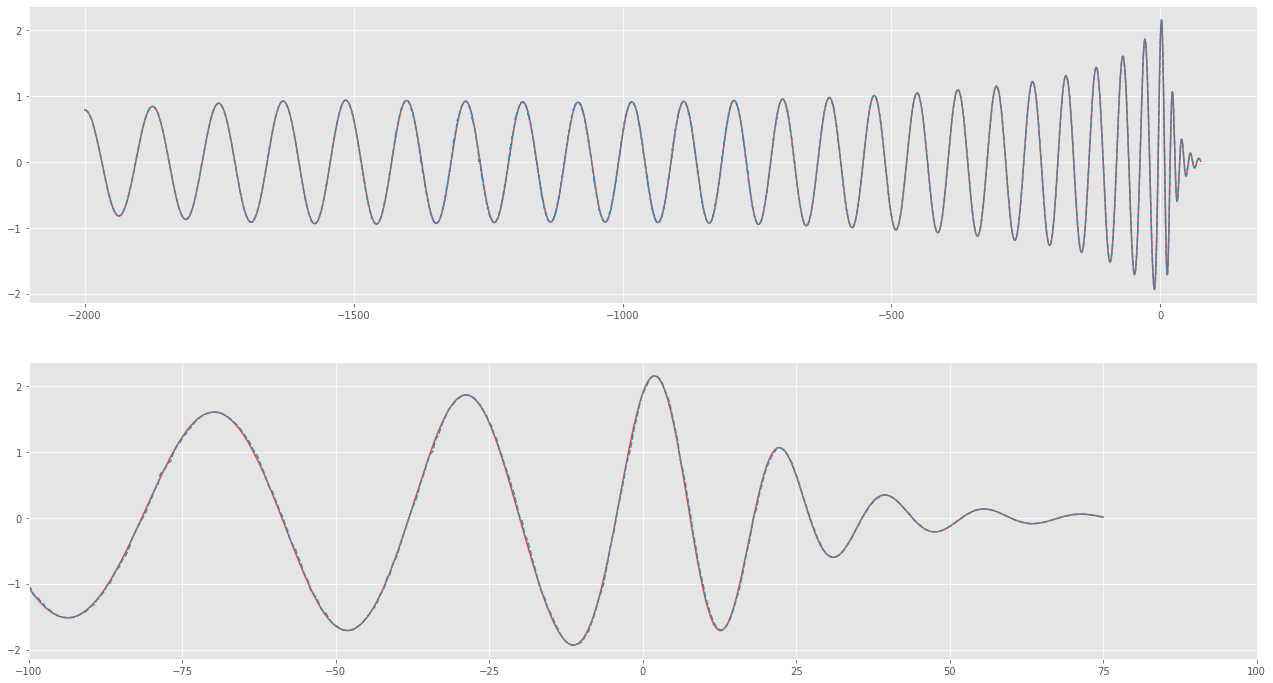

In [377]:
compare_with_models(np.around(np.random.uniform(1, 18), 3), decoder['amp'], decoder['phase'], interpolations['amp'], interpolations['phase'], base_model='IMRPhenomC')

In [ ]:
def vary_latent_space(q, decoder_amp, decoder_phase, amp_interpolations_min_max, phase_interpolations_min_max, base_model):
    
    other_model = generate_case(q, approx=base_model, data_to_model='Reh22', scale_by_eta=True, npts=5000)
    
    amp_min_val = np.asarray([f(q) for f in amp_interpolations_min_max['min']])
    amp_max_val = np.asarray([f(q) for f in amp_interpolations_min_max['max']])
    
    phase_min_val = np.asarray([f(q) for f in phase_interpolations_min_max['min']])
    phase_max_val = np.asarray([f(q) for f in phase_interpolations_min_max['max']])
    
    print(amp_min_val)
    print(amp_max_val)
    
    print(phase_min_val)
    print(phase_max_val)
    
    
    amp_latent_num = len(amp_min_val)
    phase_latent_num = len(phase_min_val)
    amp_vals = np.asarray([np.linspace(amp_min_val[i], amp_max_val[i], 10) for i in range(amp_latent_num)]).T
    phase_vals = np.asarray([np.linspace(phase_min_val[i], phase_max_val[i], 10) for i in range(phase_latent_num)]).T
    
    print(amp_vals.shape)
    
    amphat = decoder_amp.predict(amp_vals) * scale_param['amp']
    phasehat = decoder_phase.predict(phase_vals) * scale_param['phase']
    
    
    hhat = amphat * np.exp(-1.j * phasehat)
    
    wave1 = other_model['y'][0]
    wave2s = np.real(hhat)
#     wave2s = np.abs(hhat)
    
    print(f"mass-ratio: {q}")
    print(f"match: {match(wave1, wave2s[0], common_times)}")
    print(f"comparing with base_model: {base_model}")
    
    plt.figure(figsize=(22, 12))
    plt.subplot(2, 1, 1)
    plt.plot(common_times, wave1)
    for wave2 in wave2s:
        plt.plot(common_times, wave2, ls='--')
    
    plt.subplot(2, 1, 2)
    plt.plot(common_times, wave1)
    for wave2 in wave2s:
        plt.plot(common_times, wave2, ls='--')
    plt.xlim(-100, 100)

In [ ]:
vary_latent_space(np.around(np.random.uniform(1, 18), 3), decoder['amp'], decoder['phase'], interpolations_min_max['amp'], interpolations_min_max['phase'], base_model='IMRPhenomD')
# vary_latent_space(np.around(np.random.uniform(1, 18), 3), decoder['amp'], decoder['phase'], interpolations_min_max['amp'], interpolations_min_max['phase'], base_model='IMRPhenomC')
# vary_latent_space(np.around(np.random.uniform(1, 18), 3), decoder['amp'], decoder['phase'], interpolations_min_max['amp'], interpolations_min_max['phase'], base_model='SEOBNRv4_opt')